In [97]:
library(devtools)
library(ggridges)
library(expm)
set.seed(1)

load_all("../../../hmmTMB")

Loading required package: Matrix


Attaching package: ‘expm’


The following object is masked from ‘package:Matrix’:

    expm


ℹ Loading hmmTMB


In [98]:
dists <- list(
  # norm_obs       = "norm",
  # dir_obs        = "dir",
  # tweedie_obs    = "tweedie",
  mvnorm_obs     = "mvnorm"
)

params <- list(
  # norm_obs       = list(mean     = c( 0,  3),   sd       = c(1, 2)),
  # dir_obs        = list(alpha1   = c( 2,  5),   alpha2   = c( 3, 1)),
  # tweedie_obs    = list(mean     = c( 5,  10),  p        = c(0.8, 0.5),
  #                     phi      = c( 1,  2)),
  mvnorm_obs     = list(mu1      = c( 0,  2),   mu2      = c( 0, -2),
                      sd1      = c( 1,  1),   sd2      = c(1, 1),
                      corr12   = c( 0,  0))
)

evaluation_vals <- list(
  # norm_obs       = seq(-3, 3, by = 0.10),
  # dir_obs        = sapply(seq(0, 1, 0.05), function(x) {c(x, 1 - x)}),
  # tweedie_obs    = seq(0, 5, by = 0.10),
  mvnorm_obs     = t(as.matrix(expand.grid(seq(-4,4,1), seq(-4,4,1))))
)


In [99]:
n_training <- 2
training_df <- data.frame(
  ID = rep(1, n_training),
  norm_obs = c(NA, NA),
  dir_obs = c(NA, NA),
  mvnorm_obs = I(replicate(n_training, c(NA, NA), simplify = FALSE)),
  tweedie_obs = c(NA, NA)
)

tpm <- matrix(c(0.15, 0.9, 0.85, 0.1), 2, 2)
starting_state <- c(0.9, 0.1)
# crafted such that hidden state at n=1 = (0.225 0.775)
# and hidden state at n=2 = (0.73125 0.26875)

## Create True Model ----------------------------------------------------
hid_mod <- MarkovChain$new(
  data = training_df,
  n_states = 2,
  tpm = tpm
)
hid_mod$update_delta0(starting_state)
obs_mod <- Observation$new(
  data = training_df,
  n_states = 2,
  dists = dists,
  par = params
)
true_mod <- HMM$new(obs = obs_mod, hid = hid_mod)

In [100]:
n_forecast <- 2
forecast_df <- data.frame(
  ID = rep(1, n_forecast),
  norm_obs = c(NA, NA),
  dir_obs = c(NA, NA),
  mvnorm_obs = I(replicate(n_forecast, c(NA, NA), simplify = FALSE)),
  tweedie_obs = c(NA, NA)
)

forecast = Forecast$new(
  hmm = true_mod,
  forecast_data = forecast_df,
  preset_eval_range = evaluation_vals,
  starting_state_distribution = starting_state %*% tpm,
)

In [118]:
eval_dim <- apply(unique(evaluation_vals[["mvnorm_obs"]]), 1, function(row) length(unique(row)))
true_means <- do.call(rbind, params[["mvnorm_obs"]][c("mu1", "mu2")])
for (i in seq_len(n_forecast)) {
  # Forecasted means
  matrix_data <- matrix(forecast$forecast_dists()[["mvnorm_obs"]][,i], nrow = eval_dim[1], ncol = eval_dim[2])
  eval_1 <- rowSums(matrix_data)
  eval_2 <- colSums(matrix_data)
  mean_1 <- eval_1 %*% unique(evaluation_vals[["mvnorm_obs"]][1,])
  mean_2 <- eval_2 %*% unique(evaluation_vals[["mvnorm_obs"]][2,])

  # Theoretical means
  true_means <- do.call(rbind, params[["mvnorm_obs"]][c("mu1", "mu2")])
  hid_state <- starting_state %*% (tpm %^% i)
  true_mean <- true_means %*% t(hid_state)

  # Check that the forecasted means match the theoretical means
  expect_equal(mean_1[1], true_mean[1], tolerance = 0.05)
  expect_equal(mean_2[1], true_mean[2], tolerance = 0.05)

}


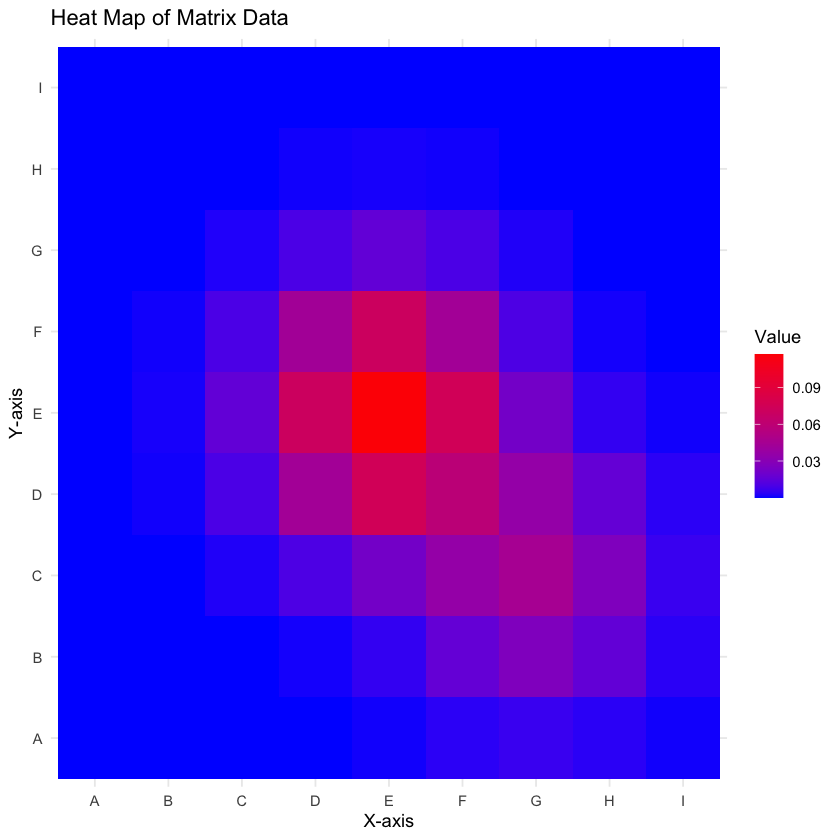

In [117]:
library(ggplot2)

# Convert matrix_data to a data frame for ggplot2
heatmap_data <- as.data.frame(as.table(matrix_data))
colnames(heatmap_data) <- c("X", "Y", "Value")

# Plot the heat map
ggplot(heatmap_data, aes(x = X, y = Y, fill = Value)) +
  geom_tile() +
  scale_fill_gradient(low = "blue", high = "red") +
  theme_minimal() +
  labs(title = "Heat Map of Matrix Data", x = "X-axis", y = "Y-axis", fill = "Value")